# Animations
In this notebook, we create animations of the particles in 2D and 3D space

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cmocean
import matplotlib.gridspec as gridspec

import matplotlib

from matplotlib.animation import FuncAnimation, writers, PillowWriter, FFMpegWriter

from glob import glob
from datetime import timedelta


from datetime import datetime
from tqdm import tqdm
from IPython.display import HTML

import matplotlib.ticker as mticker

In [2]:
path_flow = '/storage2/shared/oceanparcels/input_data/MOi/psy4v3r1/'
files = sorted(glob(path_flow + 'psy4v3r1-daily_2D_*.nc'))

start_time = datetime.strptime('2007-01-14 12:00:00', '%Y-%m-%d %H:%M:%S')
end_time = datetime.strptime('2006-10-15 12:00:00', '%Y-%m-%d %H:%M:%S')
start_index = 0 
end_index = 0

for file in files:
    if file[-13:-3] == start_time.strftime('%Y-%m-%d'):
        end_index = files.index(file)
        
    if file[-13:-3] == end_time.strftime('%Y-%m-%d'):
        start_index = files.index(file)
    
files = files[start_index:end_index+1]

mesh_mask = xr.open_dataset('/storage/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/coordinates.nc', decode_times=False)


In [3]:
files

['/storage2/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_2D_2006-10-15.nc',
 '/storage2/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_2D_2006-10-16.nc',
 '/storage2/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_2D_2006-10-17.nc',
 '/storage2/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_2D_2006-10-18.nc',
 '/storage2/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_2D_2006-10-19.nc',
 '/storage2/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_2D_2006-10-20.nc',
 '/storage2/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_2D_2006-10-21.nc',
 '/storage2/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_2D_2006-10-22.nc',
 '/storage2/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_2D_2006-10-23.nc',
 '/storage2/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_2D_2006-10-24.nc',
 '/storage2/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_2D_2006-10-25.nc',
 '/storage

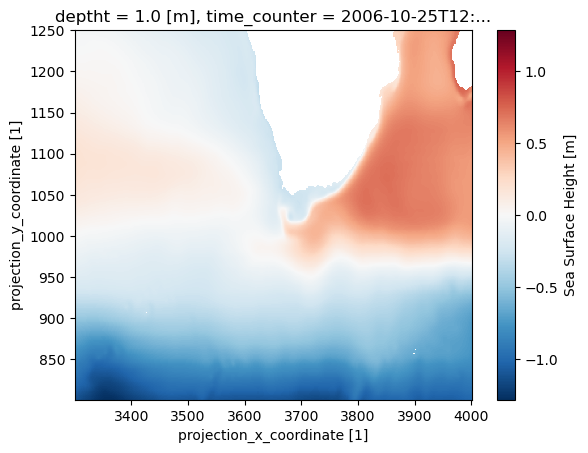

In [4]:
flow = xr.open_dataset(files[10])
indices = {'lat': range(800, 1250), 'lon': range(3300, 4000)}
flow['sossheig'][:, indices['lat'], indices['lon']].plot()

In [5]:
indices = {'lat': range(600, 1350), 'lon': range(3100, 4000)}

fields = np.zeros((len(files), len(indices['lat']), len(indices['lon'])))
time = np.zeros(len(files),dtype='datetime64[ns]')

indices = {'lat': range(600, 1350+1), 'lon': range(3100, 4000+1)}

lats = flow['nav_lat'][indices['lat'], indices['lon']].values
lons = flow['nav_lon'][indices['lat'], indices['lon']].values
lats -= lats[0,0] - lats[1,0]
lons -= lons[0,0] - lons[0,1]

indices = {'lat': range(600, 1350), 'lon': range(3100, 4000)}

In [6]:
bathy_moi = xr.load_dataset('/storage/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/bathymetry_ORCA12_V3.3.nc')
landmask = bathy_moi['mask'][indices['lat'], indices['lon']]
masked_land = np.ma.masked_where(landmask==1, landmask)

In [7]:
for i, filename in enumerate(tqdm(files)):
    T = xr.open_dataset(filename)
    fields[i] = T['sossheig'][:, indices['lat'], indices['lon']].values
    time[i] = T['time_counter'].values

#reverting fields and time
# fields = fields[::-1]
# time = time[::-1]

100%|██████████| 92/92 [00:02<00:00, 42.23it/s]


In [8]:
pset = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/hc13_3/hc13_300.zarr')
pset = pset.compute()

In [9]:
pset = pset.where(pset['z'] > 10, drop=True)
pset = pset.reindex(obs = pset.obs[::-1])

In [10]:
NPs = pset['radius'].values < 1e-6 
MPs = pset['radius'].values >= 1e-6

markersize = MPs*10 + NPs*1 + pset['radius'].values

In [11]:
markersize.shape

(8192, 4170)

In [12]:
idx = np.where(np.isnat(pset['time'][:,0].values) == False)[0][0]
starttime = pset['time'][idx, 0].values

In [13]:
start_time

datetime.datetime(2007, 1, 14, 12, 0)

In [22]:
len(files)

92

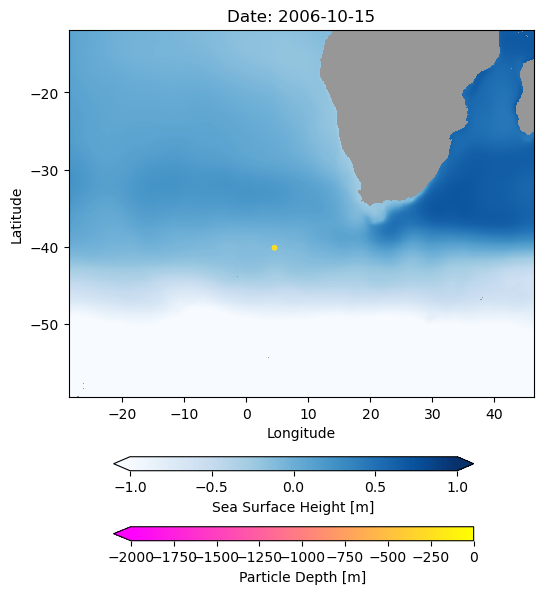

In [19]:
fig = plt.figure(figsize=(6,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])

t0 = 0

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax1.axis('off')
tracer = ax0.pcolormesh(lons, lats, fields[t0], cmap='Blues', vmin=-1, vmax=1)

ax0.pcolormesh(lons, lats, masked_land, cmap='Greys_r', vmin=-1, vmax=1)

ax0.set_xlim([lons[0,0], lons[-1,-1]])
ax0.set_ylim([lats[0,0], lats[-1,-1]])
ax0.set_xlabel('Longitude')
ax0.set_ylabel('Latitude')
time_str = str(time[t0])[:10]
title = ax0.set_title(f'Date: {time_str}')

particles = ax0.scatter(pset['lon'][:,t0], pset['lat'][:,t0], s=markersize[:,t0], c=-pset['z'][:,t0], 
                        cmap='spring', vmax=0, vmin=-2000, marker='o')

bar_ax0 = fig.add_axes([0.2, 0.25, 0.6, 0.02])
bar_ax1 = fig.add_axes([0.2, 0.15, 0.6, 0.02])

fig.colorbar(tracer, cax=bar_ax0, orientation='horizontal', 
             label='Sea Surface Height [m]', extend='both')
fig.colorbar(particles, cax=bar_ax1, orientation='horizontal', 
             label='Particle Depth [m]', extend='min')


def animate(i):
    time_str = str(time[i])[:10]
    title.set_text(f'Date: {time_str}')
    
    tracer.set_array(fields[i].ravel())
    particles.set_offsets(np.c_[pset['lon'][:,i], pset['lat'][:,i]])
    z = -pset['z'][:,i].values
    particles.set_sizes(markersize[:,i])
    particles.set_array(z.ravel())
    return tracer, particles, title


anim = FuncAnimation(fig, animate, frames=44 , interval=100, blit=True, repeat=True)

# writergif = PillowWriter(fps=30, codec="libx264")
# anim.save('../article_figs/hc11_T3600_inf.gif', writer=writergif)

# plt.show()

In [20]:
HTML(anim.to_jshtml())

In [86]:
surface_time

array([1766, 1364, 3028, ..., 1248, 1336,  767])

In [93]:
pp = pset.where(pset['z'] > 10, drop=True)

In [94]:
pp

<xarray.Dataset>
Dimensions:           (trajectory: 8192, obs: 4481)
Coordinates:
  * obs               (obs) int32 0 1 2 3 4 5 ... 4475 4476 4477 4478 4479 4480
  * trajectory        (trajectory) int64 0 1 2 3 4 ... 8187 8188 8189 8190 8191
Data variables: (12/20)
    abs_salinity      (trajectory, obs) float32 34.75 34.75 34.75 ... nan nan
    bottom            (trajectory, obs) float32 5.5e+03 5.5e+03 ... nan nan
    cons_temperature  (trajectory, obs) float32 0.755 0.7429 0.7481 ... nan nan
    density           (trajectory, obs) float32 1.028e+03 1.028e+03 ... nan nan
    distance          (trajectory, obs) float32 51.0 51.0 51.0 ... nan nan nan
    floored           (trajectory, obs) float32 0.0 0.0 0.0 0.0 ... nan nan nan
    ...                ...
    u                 (trajectory, obs) float32 0.0 3.982e-07 ... nan nan
    v                 (trajectory, obs) float32 0.0 -4.395e-07 ... nan nan
    v_s               (trajectory, obs) float32 8.861e-08 8.861e-08 ... nan nan
    w                 (trajectory, obs) float32 0.0 -0.0002692 ... nan nan
    z                 (trajectory, obs) float64 5e+03 5.023e+03 ... nan nan
    z_kz              (trajectory, obs) float32 0.0 0.8042 0.2388 ... nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.4.2-148-gb7738e92

In [95]:
pp['z'].values

array([[5000.        , 5023.23361598, 5028.86160739, ...,           nan,
                  nan,           nan],
       [5000.        , 5033.44042783, 5061.79973475, ...,           nan,
                  nan,           nan],
       [5000.        , 5016.48673461, 5027.42814779, ...,           nan,
                  nan,           nan],
       ...,
       [5000.        , 5009.61140176, 5030.62796806, ...,           nan,
                  nan,           nan],
       [5000.        , 5010.53377101, 5037.14912966, ...,           nan,
                  nan,           nan],
       [5000.        , 5024.00029586, 5045.37312516, ...,           nan,
                  nan,           nan]])